In [7]:
import tensorflow as tf
from tensorflow import keras
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from scipy import misc
import cv2 as cv
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import gc

In [2]:
path_classes = '../Img/'
classes_names = sorted(os.listdir(path_classes))
dic_imgs ={}

for i, name_class in enumerate(classes_names):
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i]))
    print "class: ", name_class, " total samples: ", len(dic_imgs[classes_names[i]])

class:  Sample001  total samples:  144
class:  Sample002  total samples:  128
class:  Sample003  total samples:  108
class:  Sample004  total samples:  80
class:  Sample005  total samples:  68
class:  Sample006  total samples:  81
class:  Sample007  total samples:  78
class:  Sample008  total samples:  83
class:  Sample009  total samples:  42
class:  Sample010  total samples:  71
class:  Sample011  total samples:  669
class:  Sample012  total samples:  146
class:  Sample013  total samples:  319
class:  Sample014  total samples:  317
class:  Sample015  total samples:  679
class:  Sample016  total samples:  129
class:  Sample017  total samples:  207
class:  Sample018  total samples:  259
class:  Sample019  total samples:  60
class:  Sample020  total samples:  100
class:  Sample021  total samples:  125
class:  Sample022  total samples:  291
class:  Sample023  total samples:  229
class:  Sample024  total samples:  474
class:  Sample025  total samples:  501
class:  Sample026  total samples:

In [23]:
X=[];
Y=[];
for i in range(len(classes_names)):
    for j in range(len(dic_imgs[classes_names[i]])):

        path_image = path_classes+classes_names[i]+'/'+dic_imgs[classes_names[i]][j];
        img=cv.imread(path_image);
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB);
        #img=cv.resize(img,(32,32));
        X.append(img)
        Y.append(i)

X=np.asanyarray(X)
Y=np.asanyarray(Y)

In [24]:
from sklearn.model_selection import train_test_split
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_size)
print X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

(5343,) (2290,) (5343,) (2290,)


In [5]:
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet')
model_ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [4]:
model_ResNet50_conv = tf.keras.models.Model(inputs=model_ResNet50.input,outputs=model_ResNet50.get_layer('res3c_branch2a').output)

(1, 224, 224, 3)


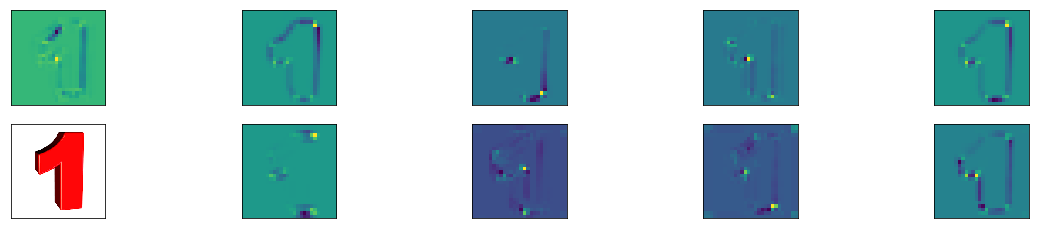

In [42]:
ran=np.random.randint(len(X_train))
img=cv.resize(X_train[ran],(224,224), interpolation = cv.INTER_CUBIC)
img = img.reshape([-1, 224, 224, 3])
features_conv1 = model_ResNet50_conv.predict(img)
plt.figure(figsize=(20,8))
for i in range(10,20,1):  
  
  src=features_conv1[0,:,:,i]
  #src=cv.resize(src,(90,90), interpolation = cv.INTER_CUBIC)
  dst = cv.cornerHarris(src,2,3,0.069)
  plt.subplot(4,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(dst, cmap='viridis')
plt.subplot(4,5,16)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_train[ran], cmap='viridis')
print img.shape

In [ ]:
img=features_conv1[0,:,:,1]*0
for i in range(30,features_conv1.shape[3],3):
    img+=features_conv1[0,:,:,i];
plt.imshow(img/128) 

In [8]:
X1=[]
Y1=[]

for i in range(len(classes_names)):
    gc.collect()
    for j in range(len(dic_imgs[classes_names[i]])):

        path_image = path_classes+classes_names[i]+'/'+dic_imgs[classes_names[i]][j];
        img=cv.imread(path_image);
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB);
        img=cv.resize(img,(224,224), interpolation = cv.INTER_CUBIC)
        img = img.reshape([-1, 224, 224, 3])
        features_conv1 = model_ResNet50_conv.predict(img)
        for h in range(20,features_conv1.shape[3]-20,60):
            X1.append(features_conv1[0,:,:,h])
            Y1.append(i)

X1=np.asanyarray(X1)
Y1=np.asanyarray(Y1)


In [9]:
print X1.shape

(15266, 28, 28)


In [10]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,test_size=test_size)

print X1_train.shape,X1_test.shape,Y1_train.shape,Y1_test.shape

(12212, 28, 28) (3054, 28, 28) (12212,) (3054,)


In [11]:

gc.collect()

6

In [12]:
X1_train = X1_train.reshape([-1, 28, 28, 1])
X1_test = X1_test.reshape([-1, 28, 28, 1])
X1_train = X1_train.astype('float32')
X1_test = X1_test.astype('float32')

X1_train /= 255
X1_test /= 255

In [13]:
model=  keras.models.Sequential()
model.add(keras.layers.Conv2D(60, (5, 5), input_shape=(28, 28,1), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(30, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(800, activation='tanh'))
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dense(250, activation='tanh'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(36, activation='softmax'))

model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 60)        1560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              7

In [14]:
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X1_train, Y1_train, epochs=100, batch_size=64,
                    validation_data=(X1_test, Y1_test))

Train on 12212 samples, validate on 3054 samples
Epoch 1/100
12212/12212 [==============================] - 14s 1ms/sample - loss: 3.5304 - acc: 0.0633 - val_loss: 3.4721 - val_acc: 0.0619
Epoch 2/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.4088 - acc: 0.0865 - val_loss: 3.3550 - val_acc: 0.0832
Epoch 3/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.3270 - acc: 0.0887 - val_loss: 3.3076 - val_acc: 0.0832
Epoch 4/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.3012 - acc: 0.0879 - val_loss: 3.2941 - val_acc: 0.0848
Epoch 5/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.2943 - acc: 0.0879 - val_loss: 3.2917 - val_acc: 0.0848
Epoch 6/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.2919 - acc: 0.0891 - val_loss: 3.2900 - val_acc: 0.0848
Epoch 7/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.2907 - acc: 0.0888 - val_lo

Epoch 59/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.2889 - acc: 0.0875 - val_loss: 3.2884 - val_acc: 0.0848
Epoch 60/100
12212/12212 [==============================] - 14s 1ms/sample - loss: 3.2891 - acc: 0.0888 - val_loss: 3.2874 - val_acc: 0.0848
Epoch 61/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.2894 - acc: 0.0888 - val_loss: 3.2875 - val_acc: 0.0848
Epoch 62/100
12212/12212 [==============================] - 13s 1ms/sample - loss: 3.2889 - acc: 0.0853 - val_loss: 3.2869 - val_acc: 0.0848
Epoch 63/100
12212/12212 [==============================] - 16s 1ms/sample - loss: 3.2892 - acc: 0.0870 - val_loss: 3.2876 - val_acc: 0.0848
Epoch 64/100
12212/12212 [==============================] - 16s 1ms/sample - loss: 3.2888 - acc: 0.0902 - val_loss: 3.2880 - val_acc: 0.0848
Epoch 65/100
12212/12212 [==============================] - 14s 1ms/sample - loss: 3.2891 - acc: 0.0905 - val_loss: 3.2876 - val_acc: 0.0848
Epoch 66/100


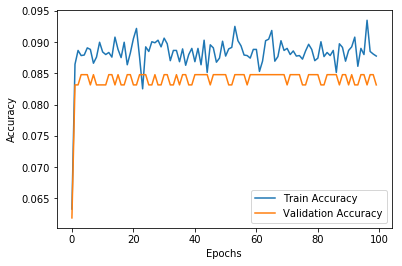

In [15]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

TypeError: Invalid dimensions for image data

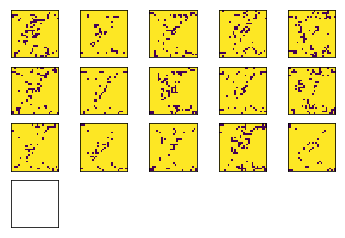

In [43]:
for i in range(15):  
  
  src=features_conv1[0,:,:,i]
  #src=cv.resize(src,(90,90), interpolation = cv.INTER_CUBIC)
  dst = cv.cornerHarris(src,2,3,0.15)
  ret1,th1 = cv.threshold(dst,(1/6)*np.mean(dst),1,cv.THRESH_BINARY)
  plt.subplot(4,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(1-th1, cmap='viridis')
plt.subplot(4,5,16)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X1_train[ran], cmap='viridis')

In [ ]:
temptry=cv.resize(X_train[ran],(224,224), interpolation = cv.INTER_CUBIC).reshape([-1, 224, 224, 3])
temp_feature=model_ResNet50_conv.predict(temptry)
print(temp_feature[0,:,:,4].shape)
dst = cv.cornerHarris(temp_feature[0,:,:,11],2,3,0.069)
plt.imshow(dst)

In [ ]:
#ret1,th1 = cv.threshold(dst,(1/6)*np.mean(dst),1,cv.THRESH_BINARY)
ret1,th1 = cv.threshold(dst,np.mean(dst),np.max(dst),cv.THRESH_BINARY)
th1=1-th1

plt.imshow(th1)

In [ ]:
def descriptor_creation(features_array,n):  
  keypoints=[]
  for i in range(n): 
    src=features_conv1[0,:,:,i]  
    dst = cv.cornerHarris(src,2,3,0.15)
    ret1,th1 = cv.threshold(dst,np.mean(dst),np.max(dst),cv.THRESH_BINARY)
    th1=1-th1
    #print th1.shape
    keypoints.append(th1)
  keypoints=np.array(keypoints)
  descriptor=[]
  for j in range(8):
    for k in range(8):
        s=keypoints[:,7*j:7*j+7,7*k:7*k+7];
        if (s.shape[1]!=0 and s.shape[2]!=0):
            descriptor.append(keypoints[:,7*j:7*j+7,7*k:7*k+7].reshape(7*7*15))
              
  return np.array(descriptor)
  
  

In [ ]:
s=descriptor_creation(features_conv1,15)

In [ ]:
from tqdm import tqdm
feature_train=[]

for i in tqdm(range(len(X_train)),desc='Train Filter Extraction'):
  temp=cv.resize(X_train[i],(224,224), interpolation = cv.INTER_CUBIC)
  temp = temp.reshape([-1, 224, 224, 3])
  features_conv1 = model_ResNet50_conv.predict(temp)   
  feature_train.append(descriptor_creation(features_conv1,15))
 
feature_train=np.array(feature_train)

In [ ]:
feature_test=[]

for j in tqdm(range(len(X_test)),desc='Test Filter Extraction'):
  temp=cv.resize(X_test[j],(224,224), interpolation = cv.INTER_CUBIC)
  temp = temp.reshape([-1, 224, 224, 3])
  features_conv1 = model_ResNet50_conv.predict(temp)  
  feature_test.append(descriptor_creation(features_conv1,15))
feature_test=np.array(feature_test)

In [ ]:
feature_train.shape,feature_test.shape

In [ ]:
y_dict=[]
for i in range(9):
  y_dict+=np.where(Y_train==i)[0][:10].tolist()

y_dict=np.array(y_dict)

In [ ]:
print(y_dict.shape)

In [ ]:
dict_use=feature_train[y_dict[0]]
for i in y_dict[1:]:
  dict_use=np.vstack((dict_use,feature_train[i]))

print(dict_use.shape)

In [ ]:
from sklearn.cluster import KMeans
v_words=60
estimator=KMeans(n_clusters=v_words,verbose=0).fit(dict_use)
dictionary=estimator.cluster_centers_ 
print (dictionary.shape)

In [ ]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [ ]:
len(dictionary)

In [ ]:
hist_train=[]
hist_test=[]

for i in tqdm(range(len(feature_train)),desc='Hist Train Creation:'):
  hist_train.append(build_histogram(feature_train[i], estimator))
 
for i in tqdm(range(len(feature_test)),desc='Hist Test Creation:'):
  hist_test.append(build_histogram(feature_test[i], estimator))
 
hist_train=np.array(hist_train)
hist_test=np.array(hist_test)

In [ ]:
plt.hist(hist_train[12],bins=60);

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

GN_est = GaussianNB()
RF_est = RandomForestClassifier(n_estimators=40)
SV_est = SVC(kernel='rbf')
KN_est = KNeighborsClassifier(n_neighbors=10)

In [ ]:
KN_est.fit(hist_train,Y_train)
KN_pr = KN_est.predict(hist_test)
print (KN_est.score(hist_test,Y_test))
cm_test = confusion_matrix(Y_test, KN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [ ]:
GN_est.fit(hist_train,Y_train)
GN_pr = GN_est.predict(hist_test)
print (GN_est.score(hist_test,Y_test))
cm_test = confusion_matrix(Y_test, GN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [ ]:
RF_est.fit(hist_train,Y_train)
RF_pr = RF_est.predict(hist_test)
print (RF_est.score(hist_test,Y_test))
cm_test = confusion_matrix(Y_test, RF_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [ ]:
SV_est.fit(hist_train,Y_train)
SV_pr = SV_est.predict(hist_test)
print (SV_est.score(hist_test,Y_test))
cm_test = confusion_matrix(Y_test, SV_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();